### Juntando todos os arquivos csv em um só data frame.
### A estrutura do dataframe consiste em :
### 1. Classificação do Cone de Luz usado: Com Grafeno (1), Sem Grafeno (0). Tipo Inteiro
### 2. Valor real do meio n1 (cover - nc) do cone de luz: Decimal
### 3. Valor real do meio n3 (substrate - ns) do cone de luz: Decimal
### 4. Valor real do meio n2 (film - nfr) do cone de luz: Decimal
### 5. Valor imaginário do meio n2 (film - nfi) do cone de luz: Decimal
### 6. Valor da frequencia (freq) naquele ponto do cone de luz: Decimal
### 7. Valor imaginário do Kx (imkx) num ponto do cone de luz: Decimal
### 8. Valor da perda (Alpha Loss - loss) para o respectivo imkx aferido num ponto do cone de luz: Decimal
$$Loss_{\alpha} = 20\frac{Im(Kx)}{ln10}$$

### Carregamento dos arquivos CSV para o Pandas Dataframe

In [28]:
import os
import pandas as pd
import numpy as np

dir_csv = '../losses'
#dir_csv_graf = '../losses_grafeno'

losses = os.listdir(dir_csv)
#graf_losses = os.listdir(dir_csv_graf)

nc = 1.0
ns = 1.98**2

pdf_losses = []
col_names = ['classif_cone_luz', 'nc', 'ns', 'nfr', 'nfi', 'freq', 'imkx', 'loss', 'img_num']

img_count = 0

for arq in losses:
    fname = dir_csv+'/'+arq
    #print(fname)
    nfr = arq.split('_')[5].split('(')[1]
    nfi = arq.split('_')[7].split(')')[0]
    pdf = pd.read_csv(fname, header=None, names=col_names[5:8])
    pdf['img_num'] = img_count
    pdf[col_names[0]] = 0
    pdf[col_names[1]] = nc
    pdf[col_names[2]] = ns
    pdf[col_names[3]] = float(nfr)
    pdf[col_names[4]] = float(nfi)
    pdf['log_loss'] = np.log10(pdf['loss'].abs())
    img_count += 1
    
    pdf_losses.append(pdf)
    
img_count = 0


'''
for arq in graf_losses:
    fname = dir_csv_graf+'/'+arq
    #print(fname)
    nfr = arq.split('_')[4].split('(')[1]
    nfi = arq.split('_')[6].split(')')[0]
    pdf = pd.read_csv(fname, header=None, names=col_names[5:8])
    pdf['img_num'] = img_count
    pdf[col_names[0]] = 1
    pdf[col_names[1]] = nc
    pdf[col_names[2]] = ns
    pdf[col_names[3]] = float(nfr)
    pdf[col_names[4]] = float(nfi)
    pdf['log_loss'] = np.log10(pdf['loss'].abs())
    img_count += 1
    
    pdf_losses.append(pdf)
'''

final_pdf = pd.concat(pdf_losses)



In [29]:
final_pdf.head()

,freq,imkx,loss,img_num,classif_cone_luz,nc,ns,nfr,nfi,log_loss
0,2.460000e+12,4944.713273,42949.233779,0,0,1.0,3.9204,11.6964,0.1,4.632955
1,2.510000e+12,8076.801566,70154.207029,0,0,1.0,3.9204,11.6964,0.1,4.846054
2,2.560000e+12,12656.969943,109937.044078,0,0,1.0,3.9204,11.6964,0.1,5.041144
3,2.610000e+12,20894.635981,181488.502156,0,0,1.0,3.9204,11.6964,0.1,5.258849
4,2.660000e+12,20894.635981,-1.000000,0,0,1.0,3.9204,11.6964,0.1,0.000000


## Separando as variaves dependentes e independentes:

In [30]:
import seaborn as sns

In [31]:
regression_base = final_pdf[['freq', 'nfi', 'imkx']]

In [32]:
regression_base.corr()

,freq,nfi,imkx
freq,1.000000e+00,1.370936e-14,-0.000936
nfi,1.370936e-14,1.000000e+00,-0.003482
imkx,-9.362341e-04,-3.481973e-03,1.000000


In [33]:
max(regression_base['nfi'])

116.9

In [34]:
regression_base['imkx_norm'] = (regression_base.imkx - min(regression_base.imkx))/(max(regression_base.imkx)-min(regression_base.imkx))

c:\Users\dmene\Anaconda3\envs\snn-pso\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
regression_base.corr()

,freq,nfi,imkx,imkx_norm
freq,1.000000e+00,1.370936e-14,-0.000936,-0.000936
nfi,1.370936e-14,1.000000e+00,-0.003482,-0.003482
imkx,-9.362341e-04,-3.481973e-03,1.000000,1.000000
imkx_norm,-9.362341e-04,-3.481973e-03,1.000000,1.000000


### Observando suas relacoes, para entender se é linear ou não. Para entender graficamente, precisamos fixar tanto um valor de frequencia ou do nfi

In [36]:
regression_base['dec_imkx_norm'] = pd.qcut(regression_base['imkx_norm'], 10, labels=False)

c:\Users\dmene\Anaconda3\envs\snn-pso\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## NFI com melhor correlação entre Frequencia e IMkx

In [38]:
nfi_list = regression_base.nfi.sort_values(ascending=True).drop_duplicates().to_list()
nfi_freq_corr = {}
for nfi in nfi_list:
    corr_freq_imkx = regression_base[regression_base.nfi==nfi].corr().freq[2]   
    print(nfi, corr_freq_imkx)
    nfi_freq_corr[nfi] = corr_freq_imkx

print(max(zip(nfi_freq_corr.values(), nfi_freq_corr.keys())))
#print(nfi_freq_corr.values())

0.1 0.14133615195328772
0.2 0.11063354592619364
0.3 0.11587861253752099
0.4 0.10022378403895936
0.5 -0.16677674879474252
0.6 0.1789437725019744
0.7 -0.17007578355392974
0.8 -0.11665514548554519
0.9 0.18151023762734206
1.0 -0.14028959881267047
1.1 0.11596286155354689
1.2 -0.15739449158361873
1.3 0.012363512458477062
1.4 0.10020398266002332
1.5 0.22277328813796898
1.6 -0.12285983362618332
1.7 0.19777567024642131
1.8 0.19233133799039548
1.9 0.20638889871029276
2.0 0.08359553285340322
2.1 0.2168656855090808
2.2 0.1519770339388375
2.3 0.15533049782463107
2.4 0.12429929621315887
2.5 0.14189635680174
2.6 0.10517282393011178
2.7 0.13708207062466712
2.8 0.10344564559525306
2.9 0.11201790999749411
3.0 0.08443360840338257
3.1 0.1737451109676071
3.2 0.1950812984160722
3.3 0.08969765975625178
3.4 0.03770600011205732
3.5 0.03987746651996486
3.6 0.07942931671817167
3.7 0.09070717644282242
3.8 0.03738697558215506
3.9 0.0633114838842442
4.0 0.027696059238600915
4.1 0.06947451791232408
4.2 0.06962862591

In [ ]:
df_agg = regression_base.groupby('dec_imkx_norm').agg({"imkx":pd.Series.nunique})
print(df_agg)

                  imkx
dec_imkx_norm         
0               4838.0
1               6364.0
2              10611.0
3              14669.0
4              14513.0
5              15164.0
6              16147.0
7              16707.0
8              15898.0
9              16746.0


### Fixando o NFi

[Text(0.5, 1.0, 'Relação de Frequencia e Im(Kx), para um Im(n2)=10')]

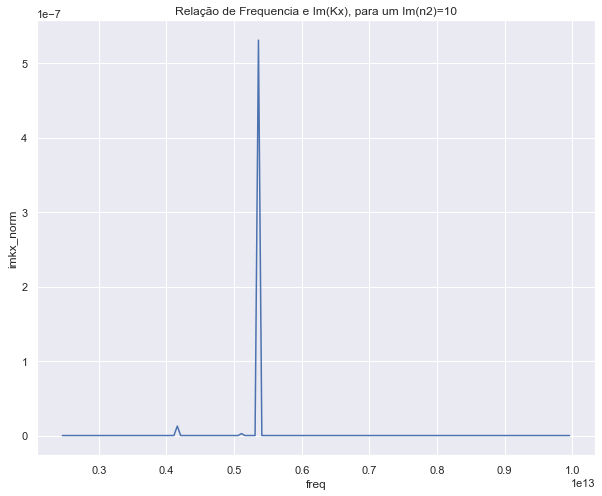

In [63]:
target_nfi = 10
reduced_base = regression_base[regression_base.nfi == target_nfi]

x = reduced_base['freq']
y = reduced_base['imkx_norm']

sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data=reduced_base, x='freq', y='imkx_norm').set(title="Relação de Frequencia e Im(Kx), para um Im(n2)={}".format(target_nfi))

### Fixando a frequencia

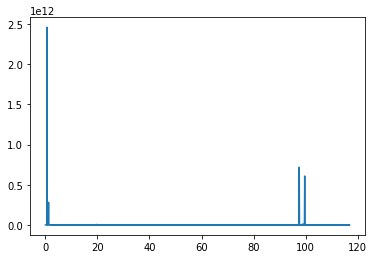

In [17]:
freq_fixed = 2.46e12
reduced_base = regression_base[regression_base.freq == freq_fixed]

x = reduced_base['nfi']
y = reduced_base['imkx']
fig, ax = plt.subplots()

ax.plot(x, y)
plt.show()

### Tamanho final do pandas DataFrame (pdf):

In [81]:
final_pdf.shape

(176519, 10)

### Entendimento das Perdas por Classe:

In [82]:
final_pdf_clean = final_pdf[final_pdf['loss'] != -1].copy()

In [120]:
#final_class_1 = final_pdf[final_pdf.classif_cone_luz == 1].copy()
final_class_0 = final_pdf_clean.copy()#final_pdf[final_pdf.classif_cone_luz == 0].copy()

quantile_num = 5

final_class_0['Decile'] = pd.qcut(final_class_0['log_loss'], quantile_num, labels=False)

In [121]:
final_class_0.Decile.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

0    20.0%
1    20.0%
2    20.0%
3    20.0%
4    20.0%
Name: Decile, dtype: object

In [122]:
#final_class_1.Decile.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

In [123]:
#final_class_0.groupby('Decile')['log_loss'].describe()

In [124]:
#final_class_1.groupby('Decile')['log_loss'].describe()

In [125]:
import matplotlib.pyplot as plt

stats_c0 = final_class_0.groupby('Decile')['log_loss'].describe()['mean']
stats_c1 = final_class_1.groupby('Decile')['log_loss'].describe()['mean']
#ax = stats_c0.plot(color='blue')
#stats_c1.plot(ax=ax, ylabel='Log10(Loss)',color='red', figsize=(12,8), title='Comparação de Perdas médias (Log10) por Decil, por Classe', legend=True)
#plt.legend(['Sem Grafeno (Classe 0)', 'Com Grafeno (Classe 1)'])

In [126]:
import matplotlib.pyplot as plt

stats_c0 = final_class_0.groupby('Decile')['log_loss'].describe()['mean']
stats_c1 = final_class_1.groupby('Decile')['log_loss'].describe()['mean']

#ax = stats_c0.plot(color='blue')
#stats_c1.plot(ax=ax, ylabel='Log10(Loss)',color='red', figsize=(12,8), title='Comparação de Perdas médias (Log10) por Decil, por Classe', legend=True)

#plt.legend(['Sem Grafeno (Classe 0)', 'Com Grafeno (Classe 1)'])

In [127]:
stats_c0 = final_class_0.groupby('Decile')['log_loss'].describe()['min']
stats_c1 = final_class_1.groupby('Decile')['log_loss'].describe()['min']

#ax = stats_c0.plot(color='blue')
#stats_c1.plot(ax=ax, ylabel='Log10(Loss)',color='red', figsize=(12,8), title='Comparação de Perdas mínimas (Log10) por Decil, por Classe', legend=True)

#plt.legend(['Sem Grafeno (Classe 0)', 'Com Grafeno (Classe 1)'])

In [128]:
stats_c0 = final_class_0.groupby('Decile')['log_loss'].describe()['max']
stats_c1 = final_class_1.groupby('Decile')['log_loss'].describe()['max']

#ax = stats_c0.plot(color='blue')
#stats_c1.plot(ax=ax, ylabel='Log10(Loss)',color='red', figsize=(12,8), title='Comparação de Perdas máximas (Log10) por Decil, por Classe', legend=True)

#plt.legend(['Sem Grafeno (Classe 0)', 'Com Grafeno (Classe 1)'])

In [129]:
stats_c0 = final_class_0.groupby('Decile')['log_loss'].describe()['25%']
stats_c1 = final_class_1.groupby('Decile')['log_loss'].describe()['25%']

#ax = stats_c0.plot(color='blue')
#stats_c1.plot(ax=ax, ylabel='Log10(Loss)',color='red', figsize=(12,8), title='Comparação de Perdas Q1 (Log10) por Decil, por Classe', legend=True)

#plt.legend(['Sem Grafeno (Classe 0)', 'Com Grafeno (Classe 1)'])

In [130]:
stats_c0 = final_class_0.groupby('Decile')['log_loss'].describe()['50%']
stats_c1 = final_class_1.groupby('Decile')['log_loss'].describe()['50%']

#ax = stats_c0.plot(color='blue')#
#stats_c1.plot(ax=ax, ylabel='Log10(Loss)',color='red', figsize=(12,8), title='Comparação de Perdas Q2 (Log10) por Decil, por Classe', legend=True)

#plt.legend(['Sem Grafeno (Classe 0)', 'Com Grafeno (Classe 1)'])

In [131]:
stats_c0 = final_class_0.groupby('Decile')['log_loss'].describe()['75%']
stats_c1 = final_class_1.groupby('Decile')['log_loss'].describe()['75%']

#ax = stats_c0.plot(color='blue')
#stats_c1.plot(ax=ax, ylabel='Log10(Loss)',color='red', figsize=(12,8), title='Comparação de Perdas Q3 (Log10) por Decil, por Classe', legend=True)

#plt.legend(['Sem Grafeno (Classe 0)', 'Com Grafeno (Classe 1)'])

### Processamento da base de dados: criando vetor de padroes de perda (valores esperados da saída do modelo)

In [132]:
img_nums = np.sort(final_class_0.img_num.unique())
img_nfis = np.sort(final_class_0.nfi.unique())

output_cols = []
for i in range(quantile_num):
    output_cols.append('d' + str(i))

output_cols

['d0', 'd1', 'd2', 'd3', 'd4']

In [133]:
img_dir = '../imgs'
images = os.listdir(img_dir)

In [134]:
df_columns = ['img_file', 'img_nfi']
df_columns += output_cols
df_columns.append('soft_label')
df_columns

['img_file', 'img_nfi', 'd0', 'd1', 'd2', 'd3', 'd4', 'soft_label']

In [135]:
df_sem_grafeno = pd.DataFrame(columns=df_columns)
df_sem_grafeno.img_file = images

for imn in img_nums:
    pdf_img = final_class_0[final_class_0['img_num'] == imn].copy()

    nfi = float(images[imn].split('_')[7].split(')')[0].replace('i', ''))
    df_sem_grafeno.loc[df_sem_grafeno.img_file == images[imn], 'img_nfi'] = nfi

    deciles = pdf_img.Decile.value_counts(normalize=True).reindex(range(quantile_num), fill_value=0)

    for i in range(quantile_num):
        df_sem_grafeno.loc[df_sem_grafeno.img_file == images[imn], output_cols[i]] = deciles[i]

    num = np.exp(deciles)
    den = np.sum(num)

    soft_max_decile = num/den

    df_sem_grafeno.loc[df_sem_grafeno.img_file == images[imn],'soft_label'] =  np.argmax(soft_max_decile)

df_sem_grafeno.sort_values('soft_label')['soft_label'].value_counts()

0    333
3    265
1    251
4    199
2    121
Name: soft_label, dtype: int64

In [139]:
df_sem_grafeno.head()

,img_file,img_nfi,d0,d1,d2,d3,d4,soft_label
0,cone_luz_sem_grafeno_n2_(11.6964_+_0.1i).jpg,0.1,0.946667,0.02,0.013333,0.013333,0.006667,0
1,cone_luz_sem_grafeno_n2_(11.6964_+_0.2i).jpg,0.2,0.827815,0.006623,0.033113,0.02649,0.10596,0
2,cone_luz_sem_grafeno_n2_(11.6964_+_0.3i).jpg,0.3,0.821192,0.02649,0.02649,0.013245,0.112583,0
3,cone_luz_sem_grafeno_n2_(11.6964_+_0.4i).jpg,0.4,0.860927,0.013245,0.02649,0.006623,0.092715,0
4,cone_luz_sem_grafeno_n2_(11.6964_+_0.5i).jpg,0.5,0.84106,0.0,0.07947,0.006623,0.072848,0


In [144]:
len(df_sem_grafeno.columns)


8

In [136]:
#df_sem_grafeno[['img_nfi',  'soft_label']].sort_values('img_nfi').plot(x='img_nfi')


In [138]:
df_sem_grafeno.to_csv('final_image_database_loss_deciles.csv', index=False)